In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm
import src.utilities.gen_synthetic as gen_syn
from src.utilities.utility_stl import Znormalization, update_array
from src.utilities.utility_frequency_analysis import peridogram, haqse, update_sDFT

import periodicity_detection as period   # AutoPeriod

## Prepare data

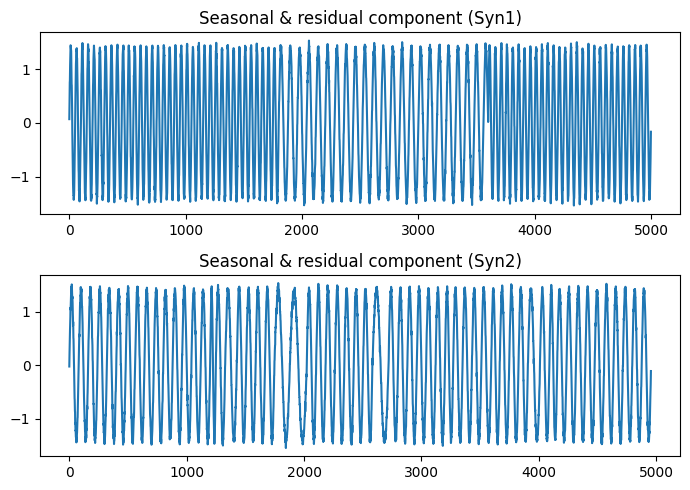

<Figure size 640x480 with 0 Axes>

In [2]:
syn1 = gen_syn.generate_syn1(is_export = False)
syn2 = gen_syn.generate_syn2(is_export = False)

# only seasonal and residual component for fair comparison 
syn1_dt = np.array(syn1['seasonal']) + np.array(syn1['residual'])
syn1_dt = Znormalization(syn1_dt)      
syn2_dt = np.array(syn2['seasonal']) + np.array(syn2['residual'])
syn2_dt = Znormalization(syn2_dt)  
# plot input data
fig, axes = plt.subplots(2, 1, figsize=(7, 5))

axes[0].plot(syn1_dt, label="syn1")
axes[0].set_title('Seasonal & residual component (Syn1)')
axes[1].plot(syn2_dt, label="syn2")
axes[1].set_title('Seasonal & residual component (Syn2)')
plt.tight_layout()
plt.show()
plt.clf()

## Reproduction of autoPERIOD (online mode) 

In [3]:
results = []            # all results
datasets = [syn1_dt, syn2_dt]
answer_lists = [syn1['main_length_ts'], syn2['main_length_ts']]
window_sizes = np.arange(160, 480, 6)
pbar = tqdm(total=(len(answer_lists)*len(window_sizes)))
for window_size in window_sizes:
    tp_count = 0
    iteration = 0
    for dataset, answer_season_length in zip(datasets, answer_lists):
        for idx in range(len(dataset) - window_size + 1):
            sliding_window = dataset[idx: window_size + idx]
            SLE_result = period.autoperiod(sliding_window)

            if SLE_result == answer_season_length[window_size + idx - 1]:
                tp_count = tp_count + 1
            iteration = iteration + 1
        pbar.update(1)
    accuracy_rate = tp_count/iteration
    results.append({'algorithm': 'AutoPERIOD',
                    'window_size': window_size,
                    'accuracy_rate': accuracy_rate})
        
pbar.close()

  0%|          | 0/108 [00:00<?, ?it/s]

## Our season length estimation

In [4]:
pbar = tqdm(total=(len(answer_lists)*len(window_sizes)))
for window_size in window_sizes:
    tp_count = 0
    iteration = 0
    for dataset, answer_season_length in zip(datasets, answer_lists):
        ## Initialization phase
        sliding_window = dataset[:window_size]
        start_fft = fft(sliding_window)
        
        # Peridogram & haqse
        xfreq, periodogram_den = peridogram(window_size, start_fft, 'rec')
        k_peak, frequency_peak = haqse(periodogram_den, sliding_window)
        SLE_result = round(1 / frequency_peak)
        
        if SLE_result == answer_season_length[window_size - 1]:
                tp_count = tp_count + 1
        iteration = iteration + 1
        
        ## Online Phase
        for idx, x_t in enumerate(dataset[window_size:]):
            x_oldest = sliding_window[0]
            sliding_window = update_array(sliding_window, x_t)
            # using SDFT
            start_fft = update_sDFT(start_fft, x_oldest, x_t)
            # Peridogram & haqse
            xfreq, periodogram_den = peridogram(window_size, start_fft, 'rec')
            k_peak, frequency_peak = haqse(periodogram_den, sliding_window)
            SLE_result = round(1 / frequency_peak)
            if SLE_result == answer_season_length[window_size + idx]:
                tp_count = tp_count + 1
            iteration = iteration + 1
        pbar.update(1)
    accuracy_rate = tp_count/iteration
    results.append({'algorithm': 'our proposed method',
                    'window_size': window_size,
                    'accuracy_rate': accuracy_rate})
pbar.close()

  0%|          | 0/108 [00:00<?, ?it/s]

## Plot results (Fig. 5a)

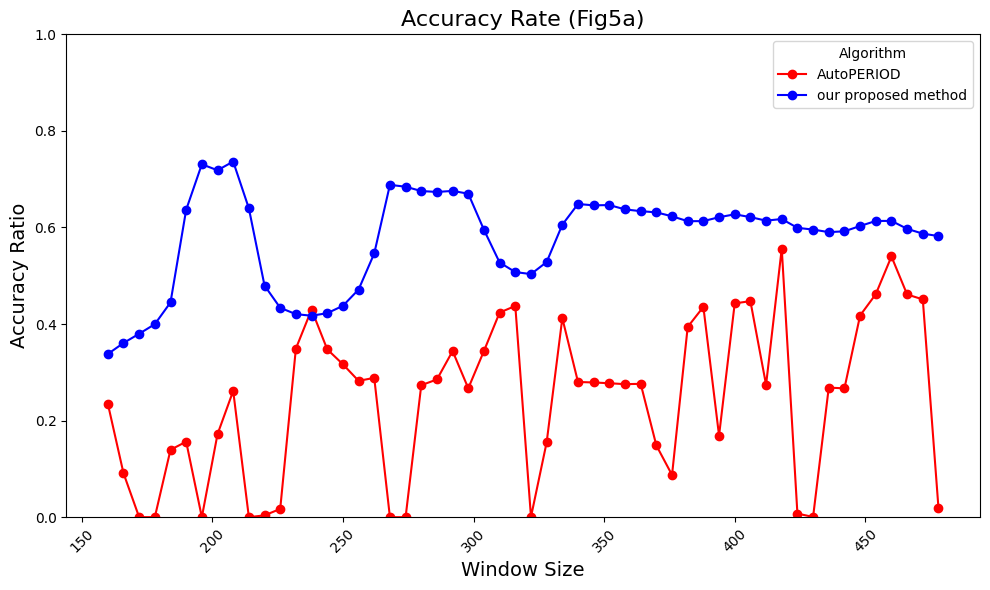

In [5]:
df = pd.DataFrame(results)
# display(df) 

algorithms = ['AutoPERIOD', 'our proposed method']
colors = ['r', 'b']
plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['window_size'], subset['accuracy_rate'], marker='o', linestyle='-', 
             color=color, label=algorithm)

plt.title('Accuracy Rate (Fig5a)', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('Accuracy Ratio', fontsize=14) 
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()
